In [201]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
import numpy as np
from numpy.random import default_rng
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from collections import defaultdict
from scipy.linalg import svd
import seaborn as sns
import multiprocessing
from functools import partial, reduce
import ruamel.yaml
yaml = ruamel.yaml.YAML()
from causal_optoconnectics.graphics import regplot, scatterplot, probplot
from causal_optoconnectics.tools import min_error
from causal_optoconnectics.core import Connectivity


# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_3/')

In [152]:
def bootstrap_ci(bs_replicates, alpha=0.05):
    low, high = np.percentile(bs_replicates, [(alpha / 2.0) * 100, (1 - alpha / 2.0) * 100])
    return low, high


def bootstrap_pvalue(case, control, obs_diff, statistic=np.mean, alpha_ci=0.05):
    diffs = case - control
    low, high = np.percentile(diffs, [(alpha_ci / 2.0) * 100, (1 - alpha_ci / 2.0) * 100])

    diffs_shifted = diffs - statistic(diffs)

    emp_diff_pctile_rnk = scipy.stats.percentileofscore(diffs_shifted, obs_diff)

    auc_left = emp_diff_pctile_rnk / 100
    auc_right = 1 - auc_left
    pval = min([auc_left, auc_right]) * 2

    return pval, low, high, diffs, obs_diff
    
def reduce_sum(dfs):
    keys = [
        'yz_sum',
        'z_sum',
        'yx_sum',
        'x_sum',
        'yxinv_sum',
        'xinv_sum',
        'y0z_sum',
        'y0x_sum',
        'y0xinv_sum',
        'n_trials'
    ]
    result = dfs[0]
    for key in keys:
        result[key] = sum([df[key].values for df in dfs])
    return result

def conditional_sum(s1, s2):
    l = [
        'yz_sum',
        'z_sum',
        'yx_sum',
        'x_sum',
        'yxinv_sum',
        'xinv_sum',
        'y0z_sum',
        'y0x_sum',
        'y0xinv_sum',
        'n_trials'
    ]
    if s1.name in l:
        return s1 + s2
    else:
        assert (s1 == s2).all()
        return s1

def compute_connectivity_from_sum(row):
    conn = Connectivity(
        compute_values=False,
        compute_sums=False
    )
    conn.__dict__.update(row.to_dict())
    conn.compute()
    result = conn.__dict__
    return result

In [136]:
n_iter = 100

In [144]:
from scipy.stats import sem

In [145]:
paths = [path for path in data_path.iterdir() if path.is_dir()]
data_df = pd.DataFrame({'path': paths})
df = {i: defaultdict(list) for i in data_df.index}
rng = default_rng()
pbar = tqdm(total=len(paths)*n_iter)
for i, row in data_df.iterrows():
    samples = [pd.read_csv(p) for p in row.path.glob('rank*.csv')]
    for ii in range(n_iter):
        # idxs = rng.choice(len(samples), size=len(samples)-10, replace=False)
        idxs = rng.choice(len(samples), size=len(samples), replace=True)
        # sample = reduce(lambda  left, right: left.combine(right, conditional_sum), [samples[i] for i in idxs])
        sample = reduce_sum([samples[j] for j in idxs])
        sample = pd.DataFrame([
            compute_connectivity_from_sum(row)
            for i, row in sample.iterrows()])
        df[i]['error_beta_did'].append(min_error(sample, 'beta_did').fun)
        df[i]['error_beta_iv_did'].append(min_error(sample, 'beta_iv_did').fun)
        df[i]['error_beta'].append(min_error(sample, 'beta').fun)
        df[i]['error_beta_iv'].append(min_error(sample, 'beta_iv').fun)
        pbar.update(1)
pbar.close()

for i, row in data_df.iterrows():
    with open(row.path / 'params.yaml', 'r') as f:
        params = yaml.load(f)
    data_df.loc[i, params.keys()] = params.values()
    data_df.loc[i, 'error_beta_did'] = np.mean(df[i]['error_beta_did'])
    data_df.loc[i, 'error_beta_iv_did'] = np.mean(df[i]['error_beta_iv_did'])
    data_df.loc[i, 'error_beta'] = np.mean(df[i]['error_beta'])
    data_df.loc[i, 'error_beta_iv'] = np.mean(df[i]['error_beta_iv'])
    
    data_df.loc[i, 'error_beta_did_ci'] = str(bootstrap_ci(df[i]['error_beta_did']))
    data_df.loc[i, 'error_beta_iv_did_ci'] = str(bootstrap_ci(df[i]['error_beta_iv_did']))
    data_df.loc[i, 'error_beta_ci'] = str(bootstrap_ci(df[i]['error_beta']))
    data_df.loc[i, 'error_beta_iv_ci'] = str(bootstrap_ci(df[i]['error_beta_iv']))
    
    data_df.loc[i, 'error_beta_did_sem'] = sem(df[i]['error_beta_did'])
    data_df.loc[i, 'error_beta_iv_did_sem'] = sem(df[i]['error_beta_iv_did'])
    data_df.loc[i, 'error_beta_sem'] = sem(df[i]['error_beta'])
    data_df.loc[i, 'error_beta_iv_sem'] = sem(df[i]['error_beta_iv'])

In [148]:
paths = [path for path in data_path.iterdir() if path.is_dir()]
observed_df = pd.DataFrame({'path': paths})
for i, row in tqdm(observed_df.iterrows(), total=len(paths)):
    samples = [pd.read_csv(p) for p in row.path.glob('rank*.csv')]
    sample = reduce_sum([samples[j] for j in idxs])
    sample = pd.DataFrame([
        compute_connectivity_from_sum(row)
        for i, row in sample.iterrows()])
    
    with open(row.path / 'params.yaml', 'r') as f:
        params = yaml.load(f)
    observed_df.loc[i, params.keys()] = params.values()
    observed_df.loc[i, 'error_beta_did'] = min_error(sample, 'beta_did').fun
    observed_df.loc[i, 'error_beta_iv_did'] = min_error(sample, 'beta_iv_did').fun
    observed_df.loc[i, 'error_beta'] = min_error(sample, 'beta').fun
    observed_df.loc[i, 'error_beta_iv'] = min_error(sample, 'beta_iv').fun


  0%|          | 0/10 [00:00<?, ?it/s]

In [150]:
np.array([df[k]['error_beta_did'] for k in range(len(df))]).shape

(10, 100)

In [160]:
pval, low, high, diffs, obs_diff = bootstrap_pvalue(
    data_df['error_beta_did'].values, observed_df['error_beta_iv_did'].values,
    (observed_df['error_beta_did'] - observed_df['error_beta_iv_did']).values.mean()
)
pval, low, high, diffs, obs_diff

(1.0,
 -2.984491429176182,
 6.556549168300645,
 array([ 3.7660141 ,  2.19056313,  7.01733242,  4.96940686,  4.91576392,
         1.78546081,  3.03800674, -3.05896539, -2.36852401, -2.72797001]),
 0.8380508526771326)

In [ ]:
data_df[['error_beta_did_ci', 'error_beta_did', 'sparsity']]

In [146]:
data_df = data_df.sort_values('sparsity')

Text(0, 0.5, '$\\mathrm{Error}$')

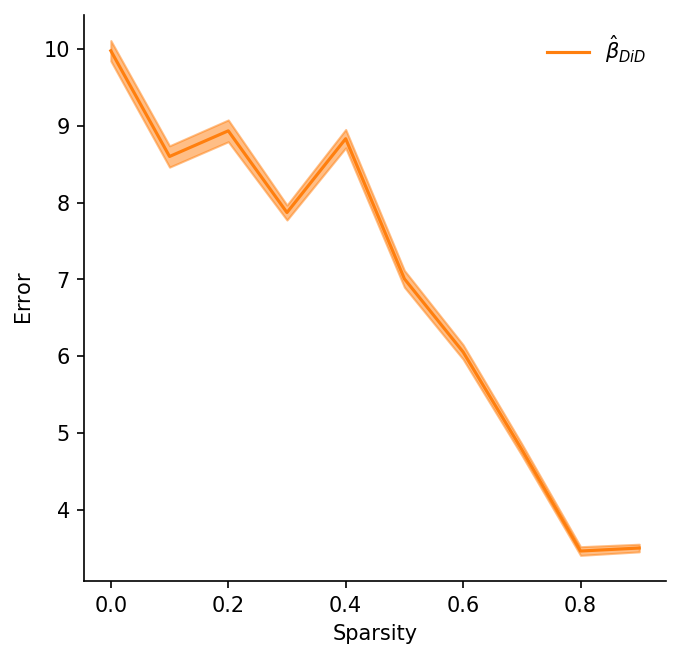

In [147]:
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)
ax.plot(data_df.sparsity, data_df['error_beta_did'], label=r'$\hat{\beta}_{DiD}$', color='C1')
# ax.fill_between(data_df.sparsity, *np.array([eval(a) for a in data_df['error_beta_did_ci'].values]).T, alpha=.5, color='C1')
ax.fill_between(data_df.sparsity, data_df['error_beta_did'] - data_df['error_beta_did_sem'], data_df['error_beta_did'] + data_df['error_beta_did_sem'], alpha=.5, color='C1')
                
# ax.plot(data_df.sparsity, data_df['error_beta_iv_did'], label=r'$\hat{\beta}_{IV,DiD}$', color='C2')
# ax.fill_between(data_df.sparsity, *np.array([eval(a) for a in data_df['error_beta_iv_did_ci'].values]).T, alpha=.5, color='C2')

# ax.plot(data_df.sparsity, data_df['error_beta'], label=r'$\hat{\beta}$', color='C3')
# ax.fill_between(data_df.sparsity, *np.array([eval(a) for a in data_df['error_beta_ci'].values]).T, alpha=.5, color='C3')

# ax.plot(data_df.sparsity, data_df['error_beta_iv'], label=r'$\hat{\beta}_{IV}$', color='C4')
# ax.fill_between(data_df.sparsity, *np.array([eval(a) for a in data_df['error_beta_iv_ci'].values]).T, alpha=.5, color='C4')

plt.legend(frameon=False)
sns.despine()
ax.set_xlabel('Sparsity')
ax.set_ylabel(r'$\mathrm{Error}$')

In [227]:
# def compute_stim_amps(params, nodes, rng):
nodes = np.arange(params['n_ex_neurons'])
def intensity(z):
    rho = params['r'] * np.sqrt((params['n'] / params['NA'])**2 - 1)
    return rho**2 / ((params['S'] * z + 1) * (z + rho)**2)

def affected_neurons(z):
    theta = np.arcsin(params['NA'] / params['n'])
    lcorr = params['r'] / np.tan(theta)
    rad = (z + lcorr) * np.tan(theta)
    A = np.pi * rad**2
    dz = z[1] - z[0]
    dV = A * dz
    density = params['n_stim'] / sum(dV)
    params['density'] = density
    N = dV * density
    return N

def hill(I):
    In = I**params['n_hill']
    return params['Imax'] * In / (params['K']**params['n_hill'] + In) # peak amplitude of the current response

# Set dc stimulation
z = np.linspace(0, params['depth'], params['n_pos'])
n_slice = affected_neurons(z).astype(int)
I = intensity(z)
A = hill(params['I0'] * I)
A = A / A.max()
idx = 0
stim_amps = {}
for i, n_stim in enumerate(n_slice):
    amp = A[i] * params['stim_strength']
    stim_amps.update({n: amp for n in nodes[idx:idx + n_stim]})
    idx += n_stim
# return stim_amps

In [224]:
n_slice

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2])

In [228]:
params['density']

1049.0761686802164

In [221]:
params = {
    'const': 5,
    'n_neurons': 1000,
    'n_ex_neurons': 800,
    'n_in_neurons': 200,
    'dt': 1e-3,
    'ref_scale': 10,
    'abs_ref_scale': 3,
    'spike_scale': 5,
    'abs_ref_strength': -100,
    'rel_ref_strength': -30,
    'stim_scale': 2,
    'stim_strength': 5,
    'stim_period': 50,
    'stim_isi_min': 10,
    'stim_isi_max': 200,
    'n_stim': 100,
    'drive_scale': 10,
    'drive_strength': -10,
    'drive_period': 100,
    'alpha': 0.2,
    'sparsity': 0.9,
    'lognormal': {
        'mu_ex': 2,
        'sigma_ex': 4,
        'low_ex': 0,
        'high_ex': 5,
        'mu_in': 4,
        'sigma_in': 4,
        'low_in': 0,
        'high_in': 5
    },
    'n_time_step': int(1e6),
    # 'seed': 12345 + rank,
    # Optogenetics
    'I0': 10, # light intensity leaving fibre mW/mm2
    'r': 100e-3, # 100 um radius of fiber
    'n': 1.36, # refraction index of gray matter
    'NA': 0.37, # Numerical Aperture of fiber
    'S': 10.3, # mm^-1 scattering index for rat, mouse = 11.2
    'n_pos': 100,
    'depth': .7,
    'Imax': 642, # max current pA
    'K': 0.84, # half-maximal light sensitivity of the ChR2 mW/mm2
    'n_hill': 0.76, # Hill coefficient
}

In [215]:
s = compute_stim_amps(params, np.arange(params['n_ex_neurons']), rng)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

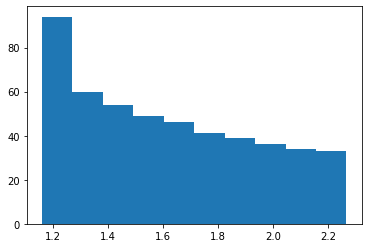

In [225]:
plt.hist(s.values());

In [183]:
np.sum(W!=0) / W.size

0.1

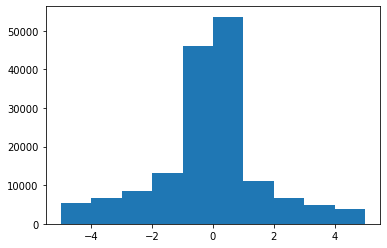

In [180]:
W[W==0] = np.nan
plt.hist(W.ravel());

In [165]:
clipped_lognormal(
        mu=2,
        sigma=4,
        size=(params['n_ex_neurons'], params['n_neurons']),
        low=0,
        high=6,
    )

array([[5.47332101e-02, 7.35496701e-01, 1.94515171e-01, ...,
        4.20633270e-01, 5.46871881e-01, 1.46906991e-01],
       [3.80064372e-01, 7.89124628e-02, 4.74479230e-02, ...,
        1.00709582e-02, 2.65937944e-02, 4.10402020e+00],
       [1.73304518e-02, 4.38911077e-02, 1.86893706e-03, ...,
        4.36331298e+00, 1.03939980e+00, 1.03636770e+00],
       ...,
       [7.20534269e-03, 7.43969292e-03, 5.71282768e-01, ...,
        4.93643098e-01, 4.21384696e-01, 7.17533695e-01],
       [2.73327091e-01, 2.10274306e+00, 4.09355313e-02, ...,
        4.65894888e-01, 1.67499770e-01, 2.89464501e-01],
       [1.45040247e-02, 1.41546880e+00, 4.82728308e+00, ...,
        5.93055971e+00, 3.90737903e+00, 8.87493829e-03]])